<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

epsilon = 1e-12
Npts    = 50

z = np.linspace(0+epsilon,1-epsilon, Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dF}{dz} &= -\frac{d b}{d z} Q, \\
\frac{dQ}{dz} &= \frac{Q}{z} + \frac{3^4}{2^6} \frac{\delta^4 z^4}{Q^2} F, \\
\end{align*}
where $F(z)$ and $Q(z)$ are the horizontally averaged (steady) buoyancy flux and volume flux respectively, we can obtain the vertical velocity produced by each of the $N_p$ plumes via the relation
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_{i=0}^{N_p} Q_i(z).
\end{equation*}
This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the dimensionless turbulence production coefficient $\delta <0$. These equations are implemented below.

In [95]:
def plume_eqns(z,X,dbdz,delta,plume_type):

    F,Q = X

    dFdz = -dbdz(z)*Q;

    if plume_type == "Rising":
      dQdz = (Q/z    ) + (pow(3,4)/pow(2,6))*(pow(delta*z    ,4)/(Q**2))*F
    elif plume_type == "Descending":
      dQdz = (Q/(z-1)) + (pow(3,4)/pow(2,6))*(pow(delta*(z-1),4)/(Q**2))*F

    return [dFdz,dQdz]

To solve these equations we first set up an ode solver using scipy, which takes the initial conditions
\begin{align*}
F &= F_0, \\
Q &= Q_0
\end{align*}
at $z=0$ for a rising plume. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$, which requires making the transform $z \to 1-z$ and then integrating from $z=1 \to 0$ until $F=0$.

In [107]:
def Plume_Solve(F0,Nsq,Q0=0,delta=-10):

    # zero crossing
    def event(t,y,*args): return y[1];
    event.terminal = True;
    event.positive = 0

    Q0  +=epsilon
    dbdz = interp1d(z,Nsq,fill_value="extrapolate")

    if F0 > 0:
      plume_type = "Rising"
      z_span = [ z[0], z[-1] ]
      z_eval = z
    elif F0 < 0:
      plume_type = "Descending"
      z_span = [ z[-1], z[0] ]
      z_eval = z[::-1]

    # Solver
    sol = solve_ivp(fun=plume_eqns,t_span=z_span, y0=[F0,Q0], t_eval=z_eval, args=(dbdz,delta,plume_type),events = event)

    #print(sol.t_events[0][0])

    # Arrange it to got from zero to one
    ind = np.argsort(sol.t, axis=0)

    F = 0.*z;
    Q = 0.*z;

    # Parse into a solution filling the entire domain
    if plume_type == "Rising":
      F[0:len(sol.y[0])] = sol.y[0][ind]
      Q[0:len(sol.y[1])] = sol.y[1][ind]
    elif plume_type== "Descending":
      F[Npts-len(sol.y[0]):] = -1.*sol.y[0][ind]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][ind]

    return F,Q

Generate rising and descending plumes

F1 0.1


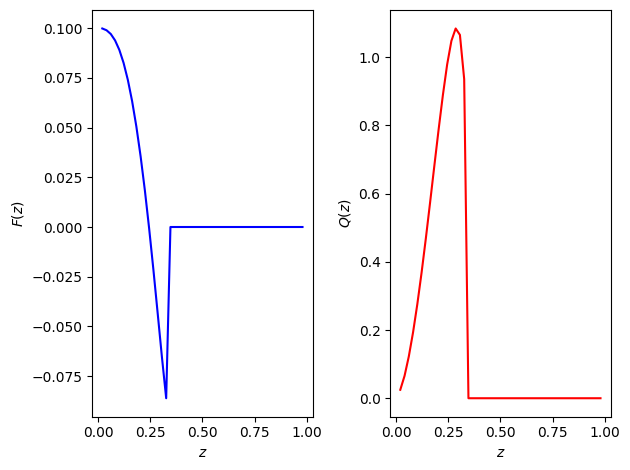

F2 -0.1


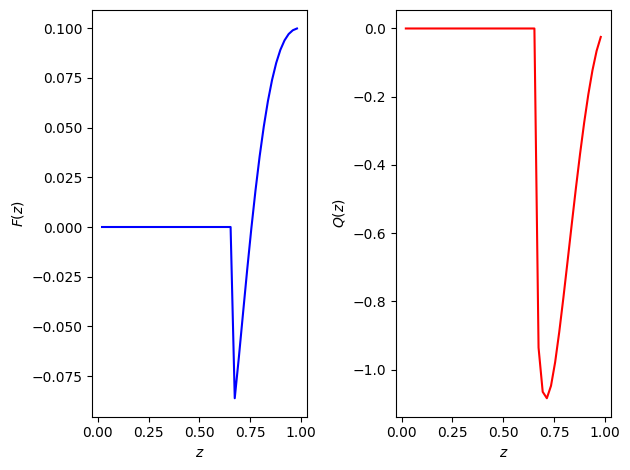

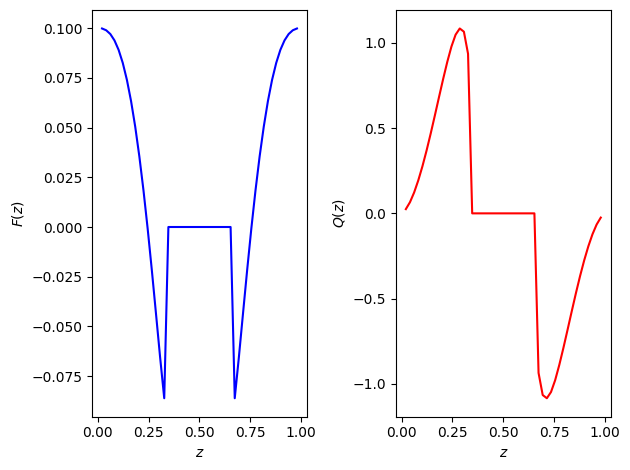

In [108]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;


# Initial conditions
Nsq    =1*(z/z)
#Plumes = {'F1':0.3,'F2':0.7,'F3':-1.0}
Plumes = {'F1':.1,'F2':-.1}


Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq); Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \sigma \frac{\partial^2 b}{\partial z^2},
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
and $\sigma$ a regularising diffusion. To do solve we implement the advection diffusion equation for buoyancy $b(z,t)$ as below

In [109]:
def step_buoyancy(w,b,σ=.1,dt=1e-03):

    """
    Step forward using one time-step

    if σ > 0:

    Crank-Nicolson

    (1/dt - σ*L/2) b_{n+1} - (1/dt - σ*L/2) b_{n} = - w D b_{n}

    if σ == 0

    Lax-Wendroff

    b_{n+1} = b_{n} - dt*w*D@b_{n} + (dt**2)/2 * w *( (D@w)*(D@b_n) + w*(L@b_n) )

    returns b(z,t_n+1)
    """

    if σ > 0:

      A = (I/dt - .5*σ*L)
      return np.linalg.solve(A,(I/dt + .5*σ*L)@b - w*(D@b) )

    elif σ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*dt)/dz > 1.:
        dt *=0.5

      return b - dt*w*(D@b) #+ ((dt**2)/2.)*w*( (D@w)*(D@b) + w*(L@b) )

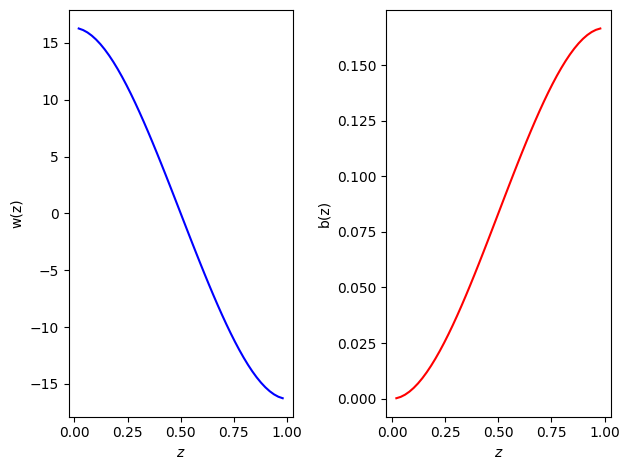

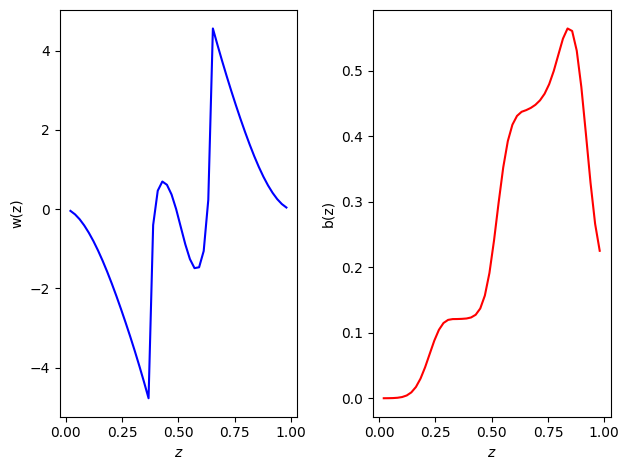

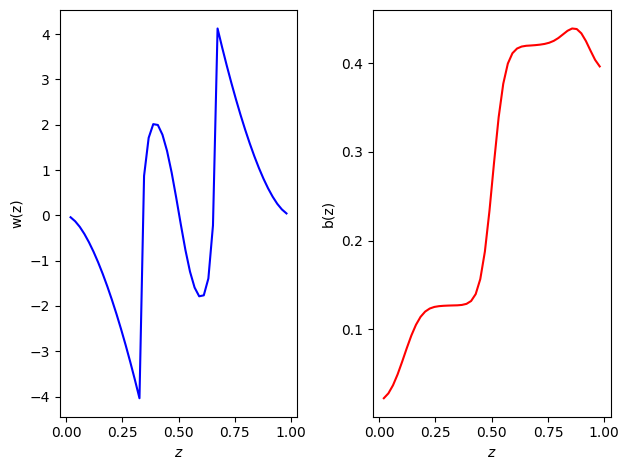

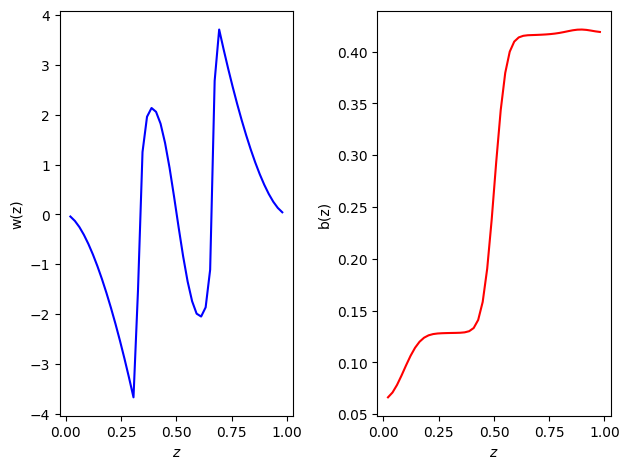

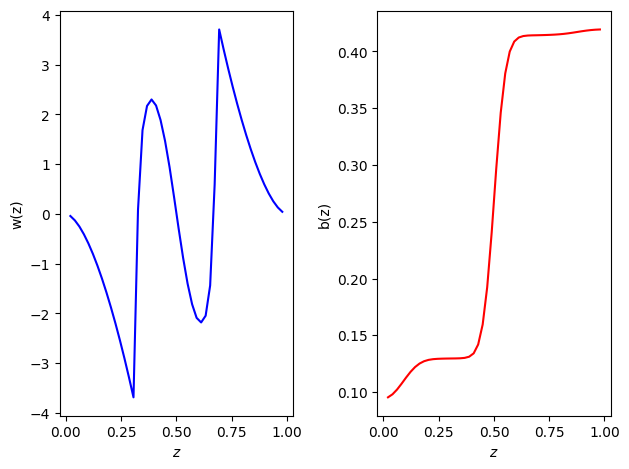

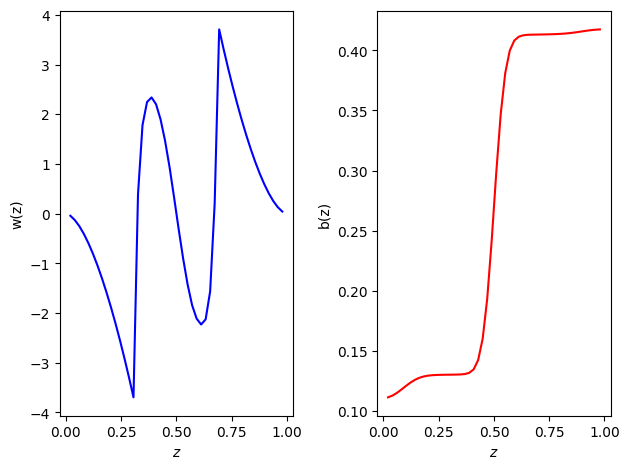

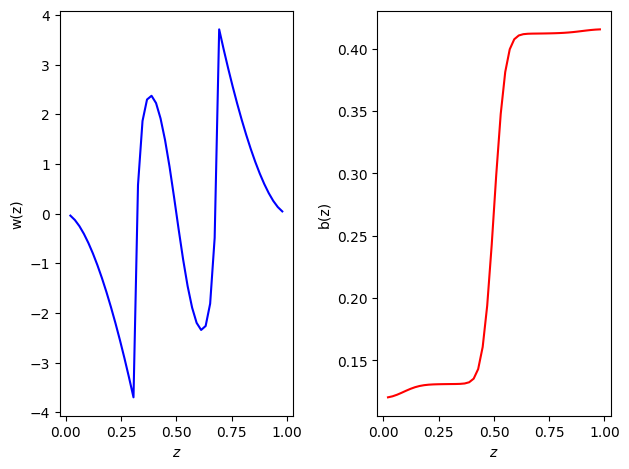

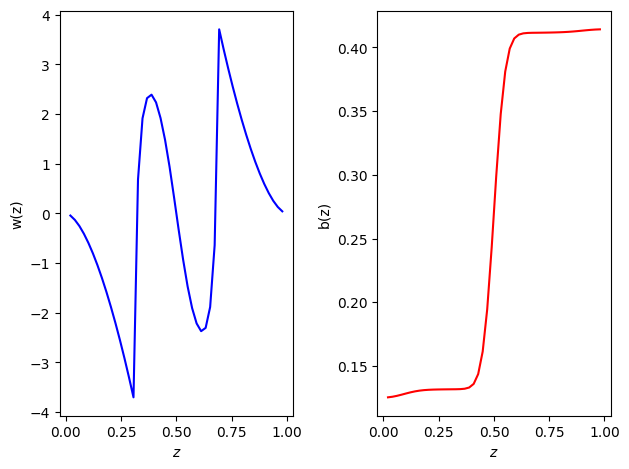

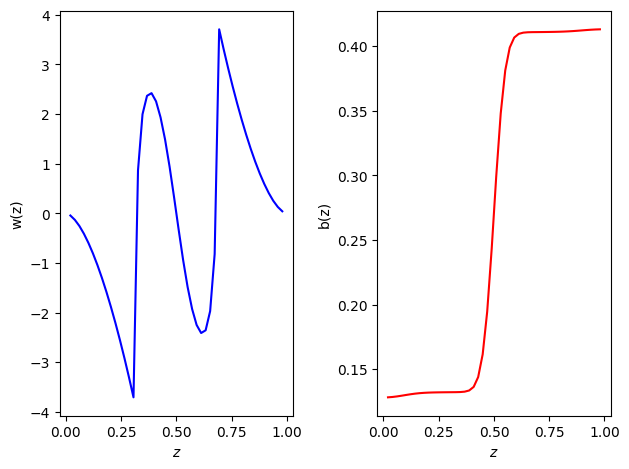

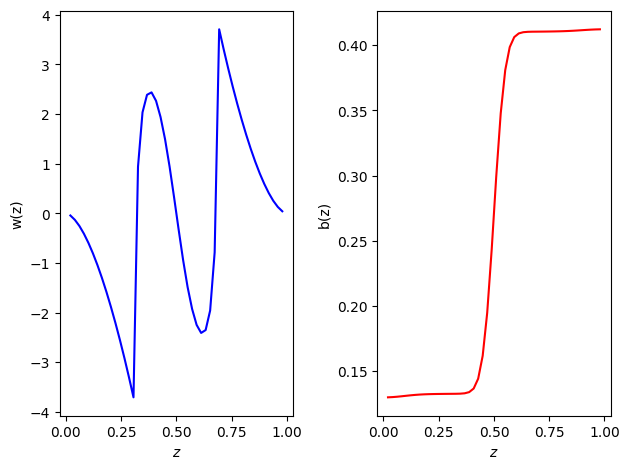

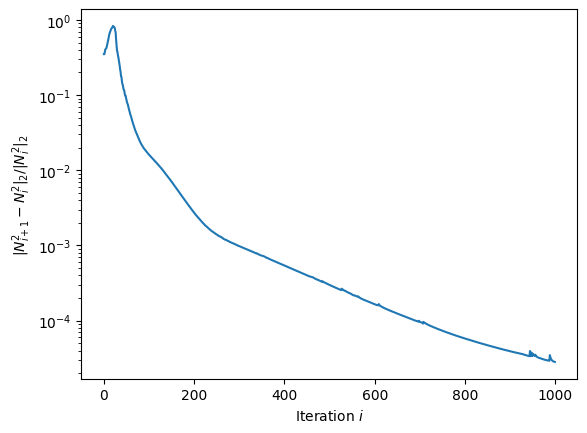

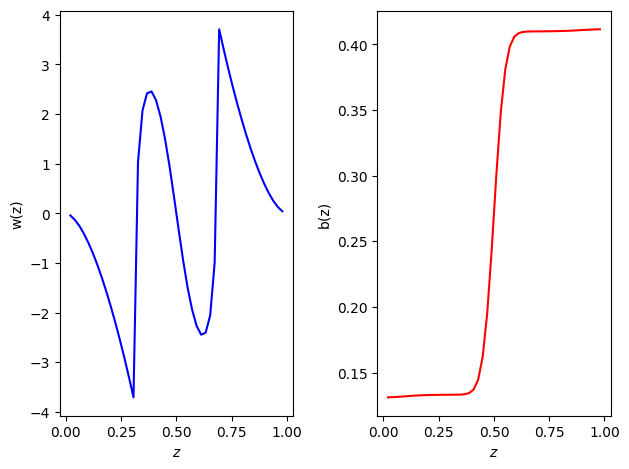

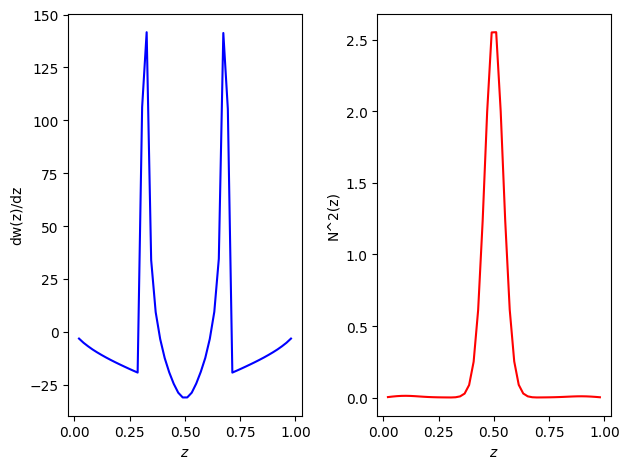

In [110]:
# Sources and IC
b      = 1*( (z**2)/2 - (z**3)/3 )
Nsq    = D@b;
Plumes = {'F1':1.0,'F2':-1.0}
Area   = 1.0


Error = []
timer = 0.
for iter in range(10**3):

  # (1) solve plume equations
  w = 0*z
  for F_key,F_value in Plumes.items():
    Q_i= Plume_Solve(F_value,Nsq)[1]
    w -= Q_i/Area

  if iter%100 ==0:
    Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

  # (2) step db/dt forward
  b = step_buoyancy(w,b,σ=0.05,dt=1e-03)

  # (3) update N^2 & check converged
  Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
  Nsq   = D@b;

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

Plot_F_and_Q(D@w,Nsq,label_f='dw(z)/dz',label_q='N^2(z)')